# 0005.0000d Modeling Strategy d

In [124]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Modeling Strategy

1. Review Starting Data, Directory Structure

2. Prepare for Modeling, Add some Features, Place into "featured" Directory 

3. Review the Features

4. Transform the Data from Time-Series to Supervised

5. Review the Transformed Data

6. Model the Transformed Data

7. Score the Model with various parameters

8. Calculate the betting return

## 1. Review Starting Data, Directory Structure

A sample directory is set up which contains a subset of the data

The directory is shown below

In [7]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [8]:
!rm -rf $SAMP_FEATURED_SUBDIRS
!rm -rf $SAMP_TRANSFORMED_SUBDIRS
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
├── 03-transformed
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    └── optimized-model.joblib

12 directories, 7 files


In [9]:
df_season_stacked = pd.read_csv(SAMP_STACKED_FP,
                                parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_season_stacked.shape

(3366, 94)

DataFrame is a bit difficult to read because it is so wide

It contains some additional columns that we are not using in this particular analysis such as asian odds and Goal difference odds.

These are dropped and the Dataframe is put into a clearer order using a utility function `clean_df`

In [10]:
df_season_stacked = clean_df(df_season_stacked)
df_season_stacked.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,h_corners,h_fouls,h_ftGoals,h_htGoals,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,a_corners,a_fouls,a_ftGoals,a_htGoals,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,awinOddsBet365,awinOddsBwa,drawOddsBbMax,drawOddsBbMean,drawOddsBet365,drawOddsBwa,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBet365,hwinOddsBwa
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,9.0,19.0,2.0,0.0,0.0,16.0,7.0,4.0,0.0,23.0,2.0,1.0,0.0,10.0,4.0,3.0,3.20,2.92,2.87,2.85,3.30,3.18,3.25,3.20,2.55,2.30,2.37,2.30
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,4.0,14.0,3.0,1.0,0.0,27.0,13.0,0.0,1.0,13.0,0.0,0.0,0.0,6.0,0.0,3.0,21.00,13.40,19.00,12.25,6.80,5.89,6.00,6.75,1.20,1.18,1.16,1.15
2,germany,bundesliga,2007-2008,bochum,sv-werder-bremen,2007-08-11,2.0,2.0,draw,7.0,15.0,2.0,0.0,0.0,17.0,4.0,1.0,6.0,17.0,2.0,2.0,0.0,20.0,9.0,2.0,2.22,1.99,2.05,1.90,3.40,3.24,3.30,3.25,3.75,3.44,3.50,3.70
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hertha-berlin,2007-08-11,1.0,0.0,hwin,6.0,13.0,1.0,1.0,0.0,19.0,5.0,2.0,5.0,13.0,0.0,0.0,0.0,10.0,3.0,1.0,3.30,2.86,2.90,2.85,3.30,3.18,3.20,3.20,2.50,2.33,2.37,2.30
4,germany,bundesliga,2007-2008,hannover,hamburger-sv,2007-08-11,0.0,1.0,awin,6.0,20.0,0.0,0.0,0.0,10.0,2.0,3.0,4.0,18.0,1.0,1.0,0.0,14.0,8.0,1.0,2.85,2.60,2.75,2.60,3.25,3.17,3.20,3.05,2.80,2.55,2.50,2.60


## 2. Prepare for Modeling, Add Some Features, Place into "featured" Directory

#### Utilities

+ One hot encode the results column
+ Make a generic Odds Column - hwinOdds, drawOdds, AwinOdds using Bet365 data
+ Add a game day to use in splitting the season for modeling
    + Walk through each game day
    + Games before game daya are used as features
    + game day games are predicted on by the model
+ Add a marker to show the percentile of the season completed

#### Features

+ Run a Poisson Regression through the season, using historical goals scored as inputs

This is acheived using the src code, which is not shown in this Notebook

The src code runs by moving data through a series of defined directories - defined as constants

We override the directory constants below, so we can run the code on the sample directories


In [11]:
from src.data import stacked_to_ts_featured as sttf
sttf.STACKED_DIR = SAMP_STACKED_DIR
sttf.FEATURED_DIR = SAMP_FEATURED_DIR
sttf.apply_ts_features()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:521: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero en

1


## 3. Review the Features

In [12]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    └── optimized-model.joblib

14 directories, 8 files


In [13]:
df_featured = pd.read_csv(SAMP_FEATURED_FP,
                          parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_featured.shape

(3366, 59)

In [14]:
df_featured.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,implied_hwin,implied_draw,implied_awin,h_impliedWin,h_impliedDraw,h_impliedLose,a_impliedWin,a_impliedDraw,a_impliedLose,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,base_hwin_prob,base_draw_prob,base_awin_prob,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,0.391387,0.285412,0.323201,0.391387,0.285412,0.323201,0.323201,0.285412,0.391387,2,0,1,0,0.003268,1.000000,0.45,0.275,0.275,9.0,19.0,0.0,NaN,NaN,NaN,0.0,16.0,7.0,4.0,0.0,23.0,1.0,NaN,NaN,NaN,0.0,10.0,4.0,3.0,2.87,3.20,2.92,2.85,3.25,3.30,3.18,3.20,2.37,2.55,2.30,2.30
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,0.797203,0.154126,0.048671,0.797203,0.154126,0.048671,0.048671,0.154126,0.797203,1,1,0,0,0.022876,0.611111,0.45,0.275,0.275,4.0,14.0,1.0,NaN,NaN,NaN,0.0,27.0,13.0,0.0,1.0,13.0,0.0,NaN,NaN,NaN,0.0,6.0,0.0,3.0,19.00,21.00,13.40,12.25,6.00,6.80,5.89,6.75,1.16,1.20,1.18,1.15
2,germany,bundesliga,2007-2008,bochum,sv-werder-bremen,2007-08-11,2.0,2.0,draw,0.265398,0.281483,0.453119,0.265398,0.281483,0.453119,0.453119,0.281483,0.265398,2,0,1,0,0.022876,1.000000,0.45,0.275,0.275,7.0,15.0,0.0,NaN,NaN,NaN,0.0,17.0,4.0,1.0,6.0,17.0,2.0,NaN,NaN,NaN,0.0,20.0,9.0,2.0,2.05,2.22,1.99,1.90,3.30,3.40,3.24,3.25,3.50,3.75,3.44,3.70
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hertha-berlin,2007-08-11,1.0,0.0,hwin,0.390951,0.289548,0.319501,0.390951,0.289548,0.319501,0.319501,0.289548,0.390951,1,1,0,0,0.022876,0.611111,0.45,0.275,0.275,6.0,13.0,1.0,NaN,NaN,NaN,0.0,19.0,5.0,2.0,5.0,13.0,0.0,NaN,NaN,NaN,0.0,10.0,3.0,1.0,2.90,3.30,2.86,2.85,3.20,3.30,3.18,3.20,2.37,2.50,2.33,2.30
4,germany,bundesliga,2007-2008,hannover,hamburger-sv,2007-08-11,0.0,1.0,awin,0.371700,0.290391,0.337909,0.371700,0.290391,0.337909,0.337909,0.290391,0.371700,3,0,0,1,0.022876,1.000000,0.45,0.275,0.275,6.0,20.0,0.0,NaN,NaN,NaN,0.0,10.0,2.0,3.0,4.0,18.0,1.0,NaN,NaN,NaN,0.0,14.0,8.0,1.0,2.75,2.85,2.60,2.60,3.20,3.25,3.17,3.05,2.50,2.80,2.55,2.60


In [15]:
df_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 59 columns):
nation              3366 non-null object
league              3366 non-null object
season              3366 non-null object
h                   3366 non-null object
a                   3366 non-null object
date                3366 non-null datetime64[ns]
h_ftGoals           3366 non-null float64
a_ftGoals           3366 non-null float64
result              3366 non-null object
implied_hwin        3366 non-null float64
implied_draw        3366 non-null float64
implied_awin        3366 non-null float64
h_impliedWin        3366 non-null float64
h_impliedDraw       3366 non-null float64
h_impliedLose       3366 non-null float64
a_impliedWin        3366 non-null float64
a_impliedDraw       3366 non-null float64
a_impliedLose       3366 non-null float64
ordinal_result      3366 non-null int64
ordinal_result_1    3366 non-null int64
ordinal_result_2    3366 non-null int64
ordinal_result_3

We want our poisson regression probabailities to be tretaed as features when we transform the data.

The code treats a column as a feature if it is prefixed by `h_` or `a_`

Therefore we need to add this prefix

In the production version of the PoissonRegression Classifier these prefixed columns will be returned

We gave 3 probabilities associated with 2 teams. One of the probabilities applies to both team - the draw probability - Explain here !!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

therefore, we will end up with each team having 2 probabilities as features - win and draw - enumerated below

Home Team
+ p(win) h_poissWin
+ p(draw) h_poissDraw
+ p(lose) h_poissLose

Away Team
+ p(win) a_poissWin
+ p(draw) a_poissDraw
+ p(lose) a_poissLose


## 4. Transform the Featured Data from Time-Series to Supervised


The source code is built to run on specific directories e.g. FEATURED_DIR, TRANSFORMED_DIR - see below - these are represented as constants

We will override these constants so we can use the same module on our sample data

Below, we can see the main function we will run on the dataframe we created above

The function that does the work is transform_ts_to_supervised

In [16]:
from src.data import transform_long_to_wide
transform_long_to_wide.FEATURED_DIR = SAMP_FEATURED_DIR
transform_long_to_wide.TRANSFORMED_DIR = SAMP_TRANSFORMED_DIR

In [17]:
run_transform_ts_to_supervised()

1


In [18]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    └── optimized-model.joblib

16 directories, 9 files


# 5. Review the Transformed Data

In [19]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [20]:
df_trans.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,a_a_corners-1,a_a_corners-2,a_a_corners-3,a_a_corners-4,a_a_corners-5,a_a_corners-6,a_a_corners-7,a_a_corners-8,a_a_corners-9,a_a_corners-10,a_a_corners-11,a_a_corners-12,a_a_corners-13,a_a_corners-14,a_a_corners-15,a_a_corners-16,a_a_fouls-0,a_a_fouls-1,a_a_fouls-2,a_a_fouls-3,a_a_fouls-4,a_a_fouls-5,a_a_fouls-6,a_a_fouls-7,a_a_fouls-8,a_a_fouls-9,a_a_fouls-10,a_a_fouls-11,a_a_fouls-12,a_a_fouls-13,a_a_fouls-14,a_a_fouls-15,a_a_fouls-16,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_htGoals-0,a_a_htGoals-1,a_a_htGoals-2,a_a_htGoals-3,a_a_htGoals-4,a_a_htGoals-5,a_a_htGoals-6,a_a_htGoals-7,a_a_htGoals-8,a_a_htGoals-9,a_a_htGoals-10,a_a_htGoals-11,a_a_htGoals-12,a_a_htGoals-13,a_a_htGoals-14,a_a_htGoals-15,a_a_htGoals-16,a_a_impliedDraw-0,a_a_impliedDraw-1,a_a_impliedDraw-2,a_a_impliedDraw-3,a_a_impliedDraw-4,a_a_impliedDraw-5,a_a_impliedDraw-6,a_a_impliedDraw-7,a_a_impliedDraw-8,a_a_impliedDraw-9,a_a_impliedDraw-10,a_a_impliedDraw-11,a_a_impliedDraw-12,a_a_impliedDraw-13,a_a_impliedDraw-14,a_a_impliedDraw-15,a_a_impliedDraw-16,a_a_impliedLose-0,a_a_impliedLose-1,a_a_impliedLose-2,a_a_impliedLose-3,a_a_impliedLose-4,a_a_impliedLose-5,a_a_impliedLose-6,a_a_impliedLose-7,a_a_impliedLose-8,a_a_impliedLose-9,a_a_impliedLose-10,a_a_impliedLose-11,a_a_impliedLose-12,a_a_impliedLose-13,a_a_impliedLose-14,a_a_impliedLose-15,a_a_impliedLose-16,a_a_impliedWin-0,a_a_impliedWin-1,a_a_impliedWin-2,a_a_impliedWin-3,a_a_impliedWin-4,a_a_impliedWin-5,a_a_impliedWin-6,a_a_impliedWin-7,a_a_impliedWin-8,a_a_impliedWin-9,a_a_impliedWin-10,a_a_impliedWin-11,a_a_impliedWin-12,a_a_impliedWin-13,a_a_impliedWin-14,a_a_impliedWin-15,a_a_impliedWin-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_redCards-0,a_a_redCards-1,a_a_redCards-2,a_a_redCards-3,a_a_redCards-4,a_a_redCards-5,a_a_redCards-6,a_a_redCards-7,a_a_redCards-8,a_a_redCards-9,a_a_redCards-10,a_a_redCards-11,a_a_redCards-12,a_a_redCards-13,a_a_redCards-14,a_a_redCards-15,a_a_redCards-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,...,h_a_yellowCards-6,h_a_yellowCards-7,h_a_yellowCards-8,h_a_yellowCards-9,h_a_yellowCards-10,h_a_yellowCards-11,h_a_yellowCards-12,h_a_yellowCards-13,h_a_yellowCards-14,h_a_yellowCards-15,h_a_yellowCards-16,h_a_yellowCards-17,h_h_corners-0,h_h_corners-1,h_h_corners-2,h_h_corners-3,h_h_corners-4,h_h_corners-5,h_

We have these historical features for each team playing a match

So, consider a mtach being played today

To get the **number of goals** scored by the **home team** in the **last 2 games** they played **at home**:
+ h_h_ftGoals-1
+ h_h_ftGoals-2

To get the **number of goals** scored by the **home team** in the **last 3 games** they played **away**:
+ h_a_ftGoals-1
+ h_a_ftGoals-2
+ h_a_ftGoals-3

To get the **poisson regression probability of winning** for the **away team** in the **last (1) game** they played **away**:
+ a_a_poissWin-1

Feature Nomenclature & Time Series to Supervised

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

DataFrame in time sequence where index 0 is the earliest game, and index max is the latest game

There are 2 teams per game `h` and `a`, where h indicates the team played at home, and a - away.

Each team has generated a feature by the end of the game - `h_feat`, and `a_feat`

There could be multiple features, meaning a double  set for each feature

Each team has a home game record and an away game record

So, there are 4 records to get for each feature
+ home team home record `h_h`
+ home team away record `h_a`
+ away team home record `a_h`
+ away team away record `a_a`

Results presented as 0, -1, -2 ... -n where 0 referes to the current game. This column can be used as a predictor variable for classification, or used as a classification response, or dropped and just the previous game features used for prediction

### Interpretation Note

`h_h_feat_-1` means:
+ (`h`) home team 
+ (`h`) home game records 
+ (`feat`) feature value in 
+ (`-1`) last game


In [21]:
df_trans.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,a_a_corners-1,a_a_corners-2,a_a_corners-3,a_a_corners-4,a_a_corners-5,a_a_corners-6,a_a_corners-7,a_a_corners-8,a_a_corners-9,a_a_corners-10,a_a_corners-11,a_a_corners-12,a_a_corners-13,a_a_corners-14,a_a_corners-15,a_a_corners-16,a_a_fouls-0,a_a_fouls-1,a_a_fouls-2,a_a_fouls-3,a_a_fouls-4,a_a_fouls-5,a_a_fouls-6,a_a_fouls-7,a_a_fouls-8,a_a_fouls-9,a_a_fouls-10,a_a_fouls-11,a_a_fouls-12,a_a_fouls-13,a_a_fouls-14,a_a_fouls-15,a_a_fouls-16,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_htGoals-0,a_a_htGoals-1,a_a_htGoals-2,a_a_htGoals-3,a_a_htGoals-4,a_a_htGoals-5,a_a_htGoals-6,a_a_htGoals-7,a_a_htGoals-8,a_a_htGoals-9,a_a_htGoals-10,a_a_htGoals-11,a_a_htGoals-12,a_a_htGoals-13,a_a_htGoals-14,a_a_htGoals-15,a_a_htGoals-16,a_a_impliedDraw-0,a_a_impliedDraw-1,a_a_impliedDraw-2,a_a_impliedDraw-3,a_a_impliedDraw-4,a_a_impliedDraw-5,a_a_impliedDraw-6,a_a_impliedDraw-7,a_a_impliedDraw-8,a_a_impliedDraw-9,a_a_impliedDraw-10,a_a_impliedDraw-11,a_a_impliedDraw-12,a_a_impliedDraw-13,a_a_impliedDraw-14,a_a_impliedDraw-15,a_a_impliedDraw-16,a_a_impliedLose-0,a_a_impliedLose-1,a_a_impliedLose-2,a_a_impliedLose-3,a_a_impliedLose-4,a_a_impliedLose-5,a_a_impliedLose-6,a_a_impliedLose-7,a_a_impliedLose-8,a_a_impliedLose-9,a_a_impliedLose-10,a_a_impliedLose-11,a_a_impliedLose-12,a_a_impliedLose-13,a_a_impliedLose-14,a_a_impliedLose-15,a_a_impliedLose-16,a_a_impliedWin-0,a_a_impliedWin-1,a_a_impliedWin-2,a_a_impliedWin-3,a_a_impliedWin-4,a_a_impliedWin-5,a_a_impliedWin-6,a_a_impliedWin-7,a_a_impliedWin-8,a_a_impliedWin-9,a_a_impliedWin-10,a_a_impliedWin-11,a_a_impliedWin-12,a_a_impliedWin-13,a_a_impliedWin-14,a_a_impliedWin-15,a_a_impliedWin-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_redCards-0,a_a_redCards-1,a_a_redCards-2,a_a_redCards-3,a_a_redCards-4,a_a_redCards-5,a_a_redCards-6,a_a_redCards-7,a_a_redCards-8,a_a_redCards-9,a_a_redCards-10,a_a_redCards-11,a_a_redCards-12,a_a_redCards-13,a_a_redCards-14,a_a_redCards-15,a_a_redCards-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,...,h_a_yellowCards-6,h_a_yellowCards-7,h_a_yellowCards-8,h_a_yellowCards-9,h_a_yellowCards-10,h_a_yellowCards-11,h_a_yellowCards-12,h_a_yellowCards-13,h_a_yellowCards-14,h_a_yellowCards-15,h_a_yellowCards-16,h_a_yellowCards-17,h_h_corners-0,h_h_corners-1,h_h_corners-2,h_h_corners-3,h_h_corners-4,h_h_corners-5,h_

## 6. Stack All Data for Modeling

In [22]:
#df_trans.info(verbose=True, null_counts=True)
df_trans.columns

Index(['nation', 'league', 'season', 'h', 'a', 'date', 'h_ftGoals', 'a_ftGoals', 'result', 'a_corners',
       ...
       'h_h_yellowCards-7', 'h_h_yellowCards-8', 'h_h_yellowCards-9', 'h_h_yellowCards-10', 'h_h_yellowCards-11', 'h_h_yellowCards-12', 'h_h_yellowCards-13', 'h_h_yellowCards-14', 'h_h_yellowCards-15', 'h_h_yellowCards-16'], dtype='object', length=1011)

As the season progresses, more historical data becomes available, which is seen in the missing data plot below

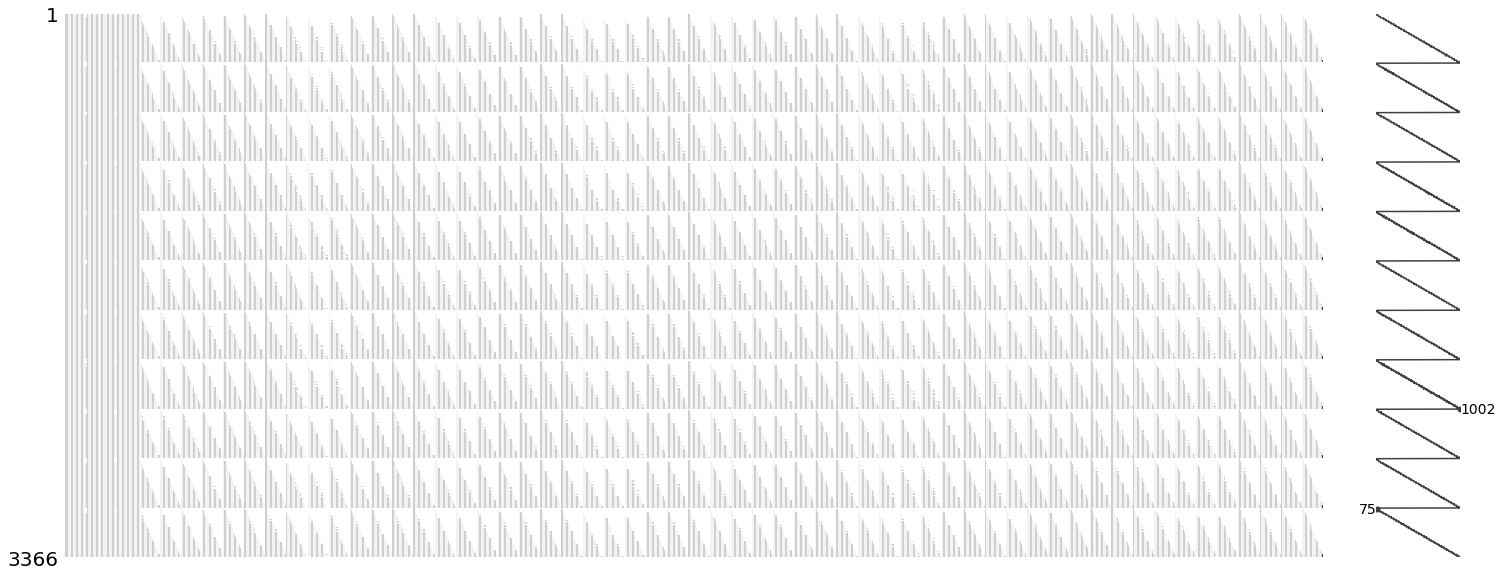

In [23]:
msno.matrix(df_trans)
plt.show();

Reviewing a single feature

As the season progresses, more historical data builds up, and the row fills in

Note thgat the suffix `_0` applies to the current game, so we need to drop these `0` columns prior to modeling

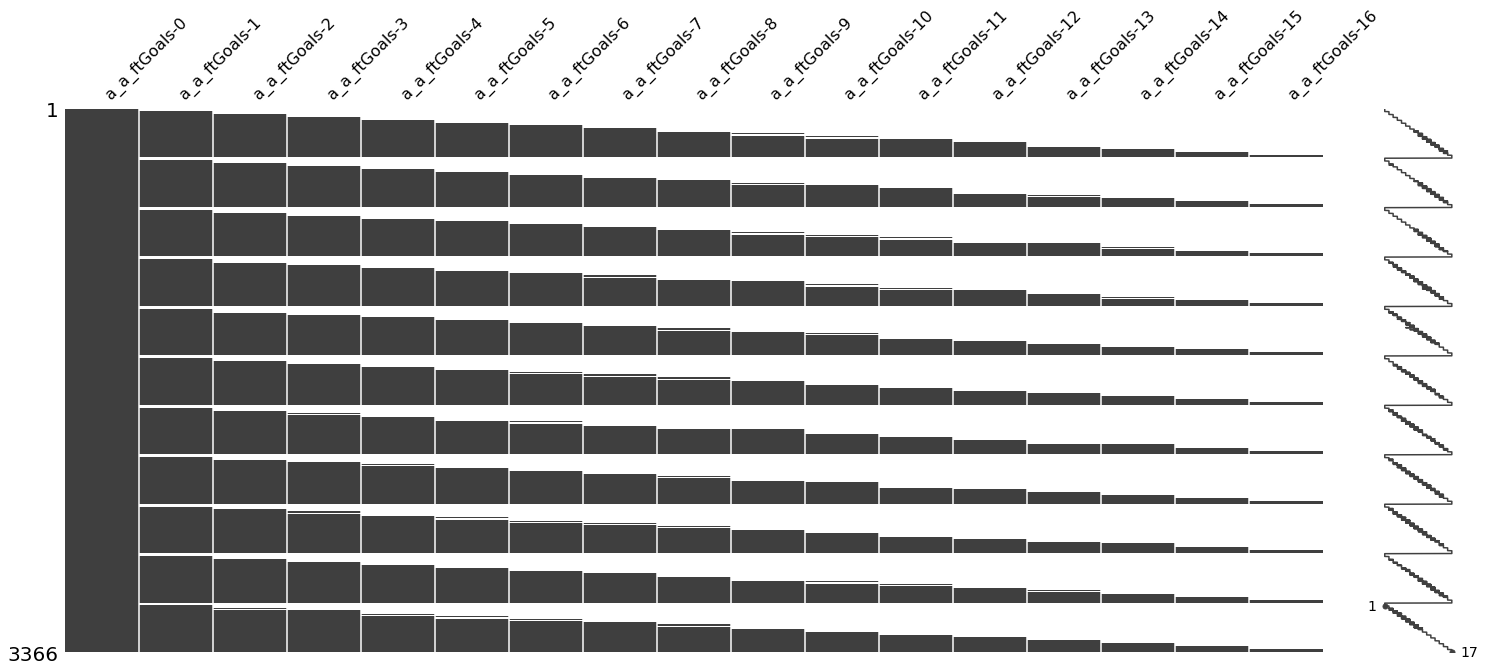

In [24]:
feat_cols = [col for col in df_trans.columns if 'a_a_ftGoals' in col]
msno.matrix(df_trans[feat_cols])
plt.show();

## 6. Select, Impute, Compress the Features

In [266]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

### Pre-Process

##### Select Features

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

#### Nomenclature

+ base_feature - ftGoals, htGoals, ...
+ feature_stub_set - h_h_ftGoals, a_a_ftGoals, h_a_ftGoals, a_h_ftGoals etc
+ feature_col_set - h_h_ftGoals-1, h_h_ftGoals-2, h_h_ftGoals-3, ..., a_h_ftGoals-16

In [267]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [268]:
selected_base_features = base_features
# selected_base_features = ['ftGoals', 'htGoals', 'shots']#  base_features
# selected_base_features = ['impliedWin', 'impliedDraw',  'impliedLose', 'poissWin', 'poissDraw', 'poissLose']#  base_features
# selected_base_features = ['redCards', 'yellowCards']#  base_features
# selected_base_features = ['corners', 'fouls']#  base_features
# selected_base_features = ['poissWin', 'poissDraw', 'poissLose',
#                           'impliedWin', 'impliedDraw', 'impliedLose',
#                          'ftGoals', 'htGoals', 'shots']#  base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17,a_a_fouls-0,h_h_fouls-0,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_fouls-6,a_h_fouls-6,h_a_fouls-6,h_h_fouls-6,a_a_fouls-7,a_h_fouls-7,h_a_fouls-7,h_h_fouls-7,a_a_fouls-8,a_h_fouls-8,h_a_fouls-8,h_h_fouls-8,a_a_fouls-9,a_h_fouls-9,h_a_fouls-9,h_h_fouls-9,a_a_fouls-10,a_h_fouls-10,h_a_fouls-10,h_h_fouls-10,a_a_fouls-11,a_h_fouls-11,h_a_fouls-11,h_h_fouls-11,a_a_fouls-12,a_h_fouls-12,h_a_fouls-12,h_h_fouls-12,a_a_fouls-13,a_h_fouls-13,h_a_fouls-13,h_h_fouls-13,a_a_fouls-14,a_h_fouls-14,h_a_fouls-14,h_h_fouls-14,a_a_fouls-15,a_h_fouls-15,h_a_fouls-15,h_h_fouls-15,a_a_fouls-16,a_h_fouls-16,h_a_fouls-16,h_h_fouls-16,a_h_fouls-17,h_a_fouls-17,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,...,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_shots-5,a_a_shotsOnTarget-5,a_h_shots-5,a_h_shotsOnTarget-5,h_a_shots-5,h_a_shotsOnTarget-5,h_h_shots-5,h_h_shotsOnTarget-5,a_a_shots-6,a_a_shotsOnTarget-6,a_h_shots-6,a_h_shotsOnTarget-6,h_a_shots-6,h_a_shotsOnTarget-6,h_h_shots-6,h_h_shotsOnTarget-6,a_a_shots-7,a_a_shotsOnTarget-7,a_h_shots-7,a_h_shotsOnTarget-7,h_a_shots-7,h_a_shotsOnTarget-7,h_h_shots-7,h_h_shotsOnTarget-7,a_a_shots-8,a_a_shotsOnTarget-8,a_h_shots-8,a_h_shotsOnTarget-8,h_a_shots-8,h_a_shots

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [269]:
n_back=2
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,germany,bundesliga,2007-2008,hamburger-sv,wolfsburg,2007-09-29,2.0,2.0,draw,5.0,21.0,0.0,0.249437,0.563486,0.187077,0.150367,0.786833,0.062767,0.0,12.0,2.0,3.0,5.0,6.10,5.19,5.00,0.275,0.275,0.45,3.75,3.75,3.52,3.65,5.0,17.0,1.0,0.249437,0.187077,0.563486,0.150367,0.062767,0.786833,0.0,20.0,6.0,0.0,1.66,1.70,1.63,1.60,0.187077,0.249437,0.563486,2,0,1,0,0.228758,1.000000,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.507860,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.0,2.

In [270]:
df_cut.shape

(2629, 183)

In [271]:
print(sum(df_cut.columns.duplicated()))

0


### Compress Feature Space

In [272]:
df_compress = df_cut.copy(deep=True)

def compress_all_features(df_orig, func='mean'):
    df = df_orig.copy(deep=True)
    feature_name_stubs = get_feature_name_stubs_from_base(df, selected_base_features)
    for feature_name_stub in feature_name_stubs:
        cols = [col for col in df.columns if '-' in col and feature_name_stub == col.rsplit('-',1)[0]]
        df[feature_name_stub + '-agg'] = df[cols].agg(func=func, axis=1)
        df.drop(columns = cols, inplace=True)
    return df

def drop_unused_features(df_orig):
    df = df_orig.copy(deep=True)
    redundant_features = [col for col in df.columns if 'agg' not in col and (col[0:2] =='h_' or col[0:2] == 'a_')]
    df.drop(columns=redundant_features, inplace=True)
    return df
    

# compressed_df = compress_all_features(df_compress, func='mean')
# compressed_df2 = drop_unused_features(compressed_df)
# compressed_df2.head()
compressed_df2 = df_compress

In [273]:
compressed_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Columns: 183 entries, nation to h_h_yellowCards-2
dtypes: datetime64[ns](1), float64(172), int64(4), object(6)
memory usage: 3.7+ MB


## Balance Features

In [274]:
compressed_df3 = compressed_df2.copy(deep=True)
compressed_df3 = compressed_df3.dropna().reset_index(drop=True)

In [275]:
# draws = compressed_df3[compressed_df3['result'] == 'draw']
# hwins = compressed_df3[compressed_df3['result'] == 'hwin'].sample(frac=0.55)
# awins = compressed_df3[compressed_df3['result'] == 'awin'].sample(frac=0.85)
# compressed_df4 = pd.concat([draws, awins, hwins], axis=0).sort_index().reset_index(drop=True)
compressed_df4 = compressed_df3.copy(deep=True)

In [276]:
# print(len(draws))
# print(len(awins))
# print(len(hwins))

In [277]:
compressed_df4.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,germany,bundesliga,2007-2008,hamburger-sv,wolfsburg,2007-09-29,2.0,2.0,draw,5.0,21.0,0.0,0.249437,0.563486,0.187077,0.150367,0.786833,0.062767,0.0,12.0,2.0,3.0,5.0,6.10,5.19,5.00,0.275,0.275,0.45,3.75,3.75,3.52,3.65,5.0,17.0,1.0,0.249437,0.187077,0.563486,0.150367,0.062767,0.786833,0.0,20.0,6.0,0.0,1.66,1.70,1.63,1.60,0.187077,0.249437,0.563486,2,0,1,0,0.228758,1.000000,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.507860,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.0,2.

In [278]:
compressed_df4.tail()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
2624,germany,bundesliga,2017-2018,leverkusen,hannover,2018-05-12,3.0,2.0,hwin,2.0,11.0,0.0,0.134756,0.792683,0.072561,0.195309,0.641564,0.163108,0.0,11.0,4.0,2.0,13.00,15.00,11.44,10.5,0.275,0.275,0.45,7.00,8.00,6.99,7.25,5.0,9.0,2.0,0.134756,0.072561,0.792683,0.195309,0.163108,0.641564,0.0,27.0,8.0,2.0,1.19,1.26,1.22,1.22,0.072561,0.134756,0.792683,1,1,0,0,1.0,0.611111,0.134756,0.134756,0.158251,0.281734,0.237103,0.199560,0.263523,0.203174,0.270632,0.251203,0.792683,0.072561,0.741801,0.364534,0.250241,0.118489,0.499307,0.647616,0.413630,0.219875,0.072561,0.792683,0.099948,0.353733,0.512656,0.681951,0.237171,0.149211,0.315738,0.528922,0.195309,0.195309,0.169177,0.277487,0.270550,0.229487,0.297829,0.152213,0.213115,0.236511,0.641564,0.163108,0.685738,0.372560,0.342978,0.155573,0.397235,0.751971,0.473646,0.234140,0.163108,0.641564,0.145010,0.349953,0.386472,0.614937,0.304935,0.095740,0.313228,0.529347,4.0,4.0,1.0,6.0,4.0,2.0,6.0,2.0,11.0,11.0,18.0,13.0,11.0,11.0,14.0,15.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0,11.0,5.0,9.0,1.0,24.0,7.0,9.0,3.0,6.0,2.0,10.0,2.0,11.0,6.0,1.0,2.0,5.0,2.0,2.0,1.0,0.0,3.0
2625,germany,bundesliga,2017-2018,mainz,sv-werder-bremen,2018-05-12,1.0,2.0,awin,7.0,6.0,1.0,0.265108,0.416763,0.318129,0.302663,0.384433,0.312903,0.0,14.0,3.0,1.0,3.00,3.05,2.89

In [279]:
import xgboost as xgb
 
 
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = {label: i for i, label in enumerate(sorted(set(y)))}
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self

## 7. Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [280]:
df_model = compressed_df4.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,hamburger-sv,wolfsburg,2007-09-29,2.0,2.0,draw,5.0,21.0,0.0,0.249437,0.563486,0.187077,0.150367,0.786833,0.062767,0.0,12.0,2.0,3.0,5.0,6.10,5.19,5.0,0.275,0.275,0.45,3.75,3.75,3.52,3.65,5.0,17.0,1.0,0.249437,0.187077,0.563486,0.150367,0.062767,0.786833,0.0,20.0,6.0,0.0,1.66,1.70,1.63,1.6,0.187077,0.249437,0.563486,2,0,1,0,0.228758,1.000000
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.0,2.15,2.04,1.9,0.275,0.275,0.45,3.50,3.60,3.26,3.30,2.0,14.0,2.0,0.268657,0.470149,0.261194,0.261955,0.312393,0.425652,0.0,11.0,4.0,1.0,3.60,3.85,3.41,3.7,0.470149,0.268657,0.261194,1,1,0,0,0.228758,0.611111


In [281]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2627,germany,bundesliga,2017-2018,hoffenheim,dortmund,2018-05-12,3.0,1.0,hwin,3.0,7.0,0.0,0.250874,0.432188,0.316938,0.201886,0.499142,0.298946,0.0,10.0,4.0,0.0,3.00,3.13,2.95,3.0,0.275,0.275,0.45,3.79,4.25,3.97,3.8,2.0,4.0,1.0,0.250874,0.316938,0.432188,0.201886,0.298946,0.499142,0.0,12.0,8.0,0.0,2.20,2.4,2.18,2.20,0.316938,0.250874,0.432188,1,1,0,0,1.0,0.611111
2628,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.50,4.98,5.0,0.275,0.275,0.45,4.00,4.36,4.11,4.1,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.7,1.64,1.65,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [282]:
meta.shape

(2629, 59)

In [283]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.50786,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,0.268657,0.268657,0.285268,0.246854,0.235385,0.284663,0.280374,0.209095,0.267606,0.286295,0.261194,0.470149,0.437854,0.148112,0.653846,0.323926,0.257009,0.099045,0.535211,0.422936,0.470149,0.261194,0.276878,0.605034,0.110769,0.391411,0.462617,0.69186,0.197183,0.290769,0.261955,0.261955,0.241919,0.220600,0.203449,0.236102,0.178841,0.296135,0.151834,0.130694,0.425652,0.312393,0.255831,0.427398,0.684202,0.627703,0.205611,0.074538,0.829690,0.768580,0.312393,0.425652,0.502249,0.351996,0.112344,0.136193,0.615461,0.629328,0.018467,1.003556e-01,3.0,4.0,6.0,1.0,7.0,6.0,1.0,5.0,22.0,16.0,26.0,28.0,20.0,16.0,22.0,12.0,1.0,1.0,3.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.0,17.0,2.0,13.0,4.0,17.0,6.0,17.0,5.0,24.0,8.0,9.0,5.0,25.0,2.0,5.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0


In [284]:
X.shape

(2629, 124)

In [285]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    2
1    1
Name: ordinal_result, dtype: int64

In [286]:
y.shape

(2629,)

### Split Into Train Test

In [287]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [288]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(2158, 59)
(2158, 124)
(2158,)

(471, 59)
(471, 124)
(471,)


### Split Out Calibrate

In [289]:
cal_seasons = ['2014-2015', '2015-2016']

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [290]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1681, 59)
(1681, 124)
(1681,)

(477, 59)
(477, 124)
(477,)


In [311]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

#from xgboost import XGBClassifier
import mord as m

# clf = m.LogisticSE(max_iter=1000, alpha=1)
# clf = m.LogisticAT(max_iter=1000, alpha=0.0) # Passable
# clf = m.LogisticIT(max_iter=100, alpha=0.0000) # Think profitable
# clf = GaussianNB(priors=[0.45, 0.275, 0.275])
# clf = MultinomialNB(class_prior=[0.45, 0.275, 0.275])
# clf = RandomForestClassifier(max_depth=25, class_weight='balanced')
# clf = MLPClassifier(learning_rate='adaptive', max_iter=1000, activation='tanh', learning_rate_init=0.001) # - good 
# clf = MLPClassifier(hidden_layer_sizes=(100, ),learning_rate='constant', max_iter=5000,
#                      activation='relu', learning_rate_init=0.0001) # good

# clf = RandomForestClassifier(class_weight='balanced', n_estimators=200,
#                              criterion='entropy', bootstrap=False, oob_score=False)

# clf = GradientBoostingClassifier() # Think Profitable
# clf = GradientBoostingClassifier(n_estimators=50,learning_rate=1.105, max_depth=10) # Think Profitable
# clf = AdaBoostClassifier()
# clf = ExtraTreesClassifier()
# clf = MLPClassifier()
# clf = QuadraticDiscriminantAnalysis(priors=[0.45, 0.275, 0.275])
# clf = QuadraticDiscriminantAnalysis()
# clf = KNeighborsClassifier(n_neighbors=30, weights='distance', algorithm='brute') # good !!
# clf = GaussianProcessClassifier()
# clf = DecisionTreeClassifier()
# clf = LogisticRegression(max_iter=1000)
# clf = XGBClassifier(objective="multi:softprob")
# clf = LinearDiscriminantAnalysis()
# clf = NuSVC(probability=True, class_weight='balanced')

n_splits=2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
srs = SelectiveMinMaxScaler(trans_col_name='')

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.465
Expected Calibration Error: 0.479
Maximum Calibration Error:  0.552
Number of Instances: 841


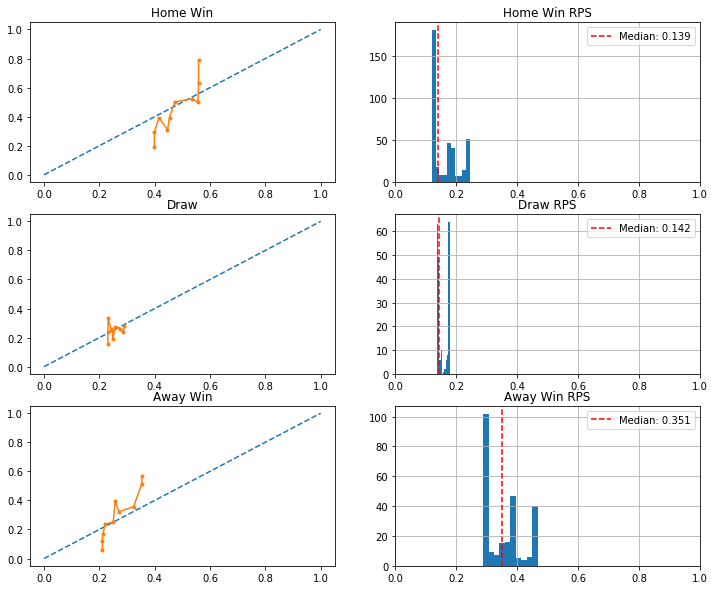


Validation Fold: 2
Average Calibration Error:  0.325
Expected Calibration Error: 0.332
Maximum Calibration Error:  0.338
Number of Instances: 840


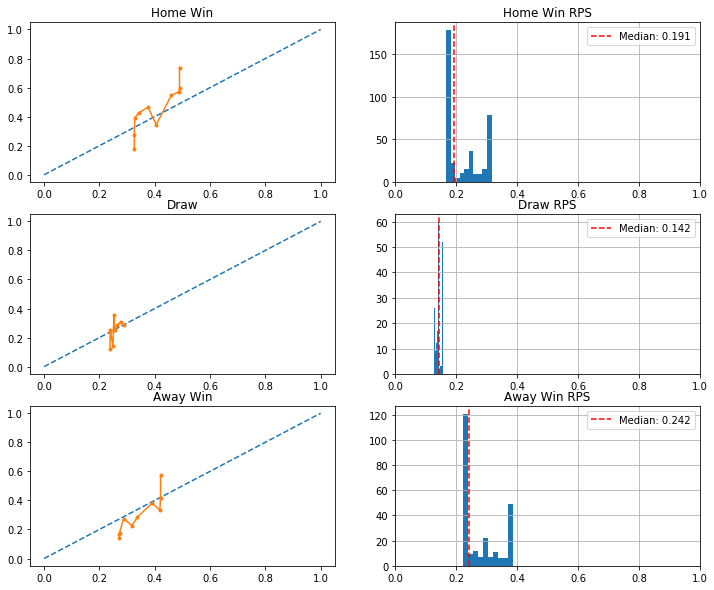

In [312]:
validate_dfs = []
n = 0
rps_adj_scores = []
bal_acc_scores = []

for fit_indices, validate_indices in skf.split(X_train_val, y_train_val):

    X_fit = X_train_val.iloc[fit_indices]
    y_fit = y_train_val.iloc[fit_indices]
    
    X_validate = X_train_val.iloc[validate_indices]
    y_validate = y_train_val.iloc[validate_indices]
    
    meta_fit = meta_train_val.iloc[fit_indices]
    meta_validate = meta_train_val.iloc[validate_indices]
    
    X_fit = srs.fit_transform(X_fit)
    clf.fit(X_fit, y_fit)
    
    X_validate = srs.transform(X_validate)
    validate_preds = clf.predict_proba(X_validate)
    
    # Probability calibration
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(X_cal, y_cal)
    sig_validate_preds = sig_clf.predict_proba(X_validate)
    
    #Build the DataFrame with the results for the validation data
    validate_preds_df = pd.DataFrame(sig_validate_preds, columns = clf.classes_, index = meta_validate.index)
    
    df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
    df_validate = insert_rps(df_validate)
    df_validate = insert_rps(df_validate,
                             prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                             return_col_prefix='bookie')
    df_validate = insert_rps(df_validate,
                             prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                             return_col_prefix='baseline')

    
    df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
    df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
    bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))

    
    df_validate['n_fold'] = n
    n += 1
    
    validate_dfs.append(df_validate)


for df in validate_dfs:
    print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
    get_model_diagnosis(df, add_baseline=True)
    plt.show();
    print()

### Review Train/Validate Shape

### Split Train into Train, Validate

from sklearn.model_selection import train_test_split
Split into Train, test, but we will also split the additional data for meta data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=None, shuffle=False)

In [79]:
meta_train.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOddsBbMax,drawOddsBbMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOddsBbMax,hwinOddsBbMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,italy,serie-a,2010-2011,fiorentina,cesena,2010-11-13,1.0,0.0,hwin,8.0,19.0,0.0,0.233766,0.649351,0.116883,0.278053,0.529130,0.192816,0.0,11.0,1.0,1.0,8.67,7.68,0.275,0.275,0.45,4.26,3.95,5.0,12.0,0.0,0.233766,0.116883,0.649351,0.278053,0.192816,0.529130,0.0,14.0,3.0,2.0,1.56,1.47,0.116883,0.233766,0.649351,1,1,0,0,0.294737,0.611111
1,italy,serie-a,2010-2011,bari,parma,2010-11-14,0.0,1.0,awin,2.0,18.0,1.0,0.292093,0.406391,0.301516,0.346089,0.379769,0.274142,0.0,9.0,2.0,2.0,3.50,3.30,0.275,0.275,0.45,3.30,3.14,6.0,22.0,0.0,0.292093,0.301516,0.406391,0.346089,0.274142,0.379769,2.0,18.0,4.0,1.0,2.36,2.25,0.301516,0.292093,0.406391,3,0,0,1,0.315789,1.000000
2,italy,serie-a,2010-2011,ac-milan,fiorentina,2010-11-20,1.0,0.0,hwin,2.0,10.0,0.0,0.249157,0.595120,0.155723,0.172085,0.725602,0.102286,1.0,10.0,6.0,0.0,7.06,6.29,0.275,0.275,0.45,4.04,3.75,7.0,14.0,1.0,0.249157,0.155723,0.595120,0.172085,0.102286,0.725602,0.0,18.0,6.0,2.0,1.61,1.56,0.155723,0.249157,0.595120,1,1,0,0,0.321053,0.611111
3,italy,serie-a,2010-2011,as-roma,udinese,2010-11-20,2.0,0.0,hwin,6.0,18.0,0.0,0.289389,0.522508,0.188103,0.257601,0.489087,0.253311,0.0,25.0,6.0,2.0,5.50,4.94,0.275,0.275,0.45,3.55,3.36,6.0,23.0,1.0,0.289389,0.188103,0.522508,0.257601,0.253311,0.489087,1.0,13.0,5.0,2.0,1.86,1.77,0.188103,0.289389,0.522508,1,1,0,0,0.321053,0.611111
4,italy,serie-a,2010-2011,catania,bari,2010-11-21,1.0,0.0,hwin,2.0,19.0,0.0,0.259954,0.596072,0.143974,0.271960,0.580041,0.147999,0.0,7.0,0.0,4.0,7.12,6.18,0.275,0.275,0.45,3.91,3.61,11.0,15.0,0.0,0.259954,0.143974,0.596072,0.271960,0.147999,0.580041,1.0,16.0,6.0,2.0,1.65,1.59,0.143974,0.259954,0.596072,1,1,0,0,0.342105,0.611111


In [80]:
meta_train.tail()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOddsBbMax,drawOddsBbMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOddsBbMax,hwinOddsBbMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
1380,italy,serie-a,2015-2016,as-roma,frosinone,2016-01-30,3.0,1.0,hwin,8.0,13.0,1.0,0.158277,0.778412,0.063311,0.096410,0.848086,0.054735,0.0,13.0,3.0,2.0,16.88,13.61,0.275,0.275,0.45,7.12,6.34,11.0,17.0,1.0,0.158277,0.063311,0.778412,0.096410,0.054735,0.848086,0.0,22.0,6.0,1.0,1.26,1.21,0.063311,0.158277,0.778412,1,1,0,0,0.560526,0.611111
1381,italy,serie-a,2015-2016,atalanta,sassuolo,2016-01-30,1.0,1.0,draw,5.0,17.0,1.0,0.298805,0.382470,0.318725,0.327375,0.335816,0.336810,0.0,9.0,1.0,4.0,3.33,3.03,0.275,0.275,0.45,3.30,3.13,3.0,24.0,1.0,0.298805,0.318725,0.382470,0.327375,0.336810,0.335816,0.0,6.0,5.0,2.0,2.54,2.46,0.318725,0.298805,0.382470,2,0,1,0,0.560526,1.000000
1382,italy,serie-a,2015-2016,carpi,palermo,2016-01-30,1.0,1.0,draw,4.0,13.0,1.0,0.299248,0.445393,0.255359,0.259979,0.407449,0.332571,0.0,5.0,1.0,3.0,3.75,3.41,0.275,0.275,0.45,3.43,3.20,7.0,22.0,0.0,0.299248,0.255359,0.445393,0.259979,0.332571,0.407449,0.0,13.0,1.0,2.0,2.30,2.23,0.255359,0.299248,0.445393,2,0,1,0,0.560526,1.000000
1383,italy,serie-a,2015-2016,torino,verona,2016-01-31,0.0,0.0,draw,2.0,18.0,0.0,0.238095,0.634921,0.126984,0.236168,0.635007,0.128823,0.0,10.0,3.0,4.0,7.62,6.92,0.275,0.275,0.45,4.38,4.09,5.0,13.0,0.0,0.238095,0.126984,0.634921,0.236168,0.128823,0.635007,0.0,16.0,6.0,0.0,1.54,1.50,0.126984,0.238095,0.634921,2,0,1,0,0.578947,1.000000
1384,italy,serie-a,2015-2016,napoli,empoli,2016-01-31,5.0,1.0,hwin,3.0,15.0,1.0,0.158730,0.761905,0.079365,0.175491,0.712383,0.112099,0.0,7.0,2.0,3.0,13.00,11.00,0.275,0.275,0.45,6.05,5.52,4.0,11.0,2.0,0.158730,0.079365,0.761905,0.175491,0.112099,0.712383,0.0,20.0,6.0,3.0,1.33,1.28,0.079365,0.158730,0.761905,1,1,0,0,0.578947,0.611111


In [81]:
meta_test.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOddsBbMax,drawOddsBbMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOddsBbMax,hwinOddsBbMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
1385,italy,serie-a,2015-2016,udinese,lazio,2016-01-31,0.0,0.0,draw,5.0,19.0,0.0,0.288462,0.288462,0.423077,0.258742,0.300875,0.440383,1.0,17.0,1.0,4.0,2.40,2.32,0.275,0.275,0.45,3.38,3.21,5.0,8.0,0.0,0.288462,0.423077,0.288462,0.258742,0.440383,0.300875,1.0,11.0,1.0,2.0,3.39,3.18,0.423077,0.288462,0.288462,2,0,1,0,0.578947,1.000000
1386,italy,serie-a,2015-2016,genoa,fiorentina,2016-01-31,0.0,0.0,draw,6.0,15.0,0.0,0.279718,0.306787,0.413495,0.249724,0.237092,0.513183,0.0,11.0,3.0,3.0,2.41,2.34,0.275,0.275,0.45,3.55,3.30,7.0,13.0,0.0,0.279718,0.413495,0.306787,0.249724,0.513183,0.237092,0.0,11.0,2.0,2.0,3.30,3.08,0.413495,0.279718,0.306787,2,0,1,0,0.578947,1.000000
1387,italy,serie-a,2015-2016,bologna,sampdoria,2016-01-31,3.0,2.0,hwin,4.0,14.0,0.0,0.287507,0.462816,0.249677,0.237634,0.470096,0.292268,0.0,14.0,6.0,5.0,4.00,3.58,0.275,0.275,0.45,3.49,3.27,3.0,13.0,2.0,0.287507,0.249677,0.462816,0.237634,0.292268,0.470096,0.0,7.0,5.0,3.0,2.30,2.13,0.249677,0.287507,0.462816,1,1,0,0,0.578947,0.611111
1388,italy,serie-a,2015-2016,ac-milan,inter,2016-01-31,3.0,0.0,hwin,6.0,16.0,0.0,0.288514,0.413955,0.297530,0.331989,0.308313,0.359698,0.0,12.0,3.0,1.0,3.20,2.96,0.275,0.275,0.45,3.49,3.26,5.0,18.0,1.0,0.288514,0.297530,0.413955,0.331989,0.359698,0.308313,0.0,14.0,5.0,3.0,2.63,2.45,0.297530,0.288514,0.413955,1,1,0,0,0.578947,0.611111
1389,italy,serie-a,2015-2016,chievo,juventus,2016-01-31,0.0,4.0,awin,4.0,7.0,2.0,0.250606,0.126974,0.622420,0.268154,0.208493,0.523353,0.0,30.0,10.0,2.0,1.62,1.54,0.275,0.275,0.45,4.00,3.80,0.0,12.0,0.0,0.250606,0.622420,0.126974,0.268154,0.523353,0.208493,0.0,6.0,2.0,3.0,8.10,6.98,0.622420,0.250606,0.126974,3,0,0,1,0.578947,1.000000


In [82]:
meta_test.tail()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOddsBbMax,drawOddsBbMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOddsBbMax,hwinOddsBbMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2063,italy,serie-a,2017-2018,genoa,torino,2018-05-20,1.0,2.0,awin,3.0,11.0,1.0,0.272349,0.363825,0.363825,0.317809,0.287406,0.394785,0.0,4.0,2.0,3.0,2.75,2.61,0.275,0.275,0.45,3.80,3.58,7.0,10.0,0.0,0.272349,0.363825,0.363825,0.317809,0.394785,0.287406,0.0,12.0,2.0,1.0,2.69,2.56,0.363825,0.272349,0.363825,3,0,0,1,1.0,1.000000
2064,italy,serie-a,2017-2018,lazio,inter,2018-05-20,2.0,3.0,awin,4.0,13.0,1.0,0.272834,0.397883,0.329283,0.244073,0.376581,0.379345,0.0,15.0,6.0,4.0,3.00,2.79,0.275,0.275,0.45,3.70,3.51,10.0,12.0,2.0,0.272834,0.329283,0.397883,0.244073,0.379345,0.376581,2.0,14.0,4.0,5.0,2.58,2.44,0.329283,0.272834,0.397883,3,0,0,1,1.0,1.000000
2065,italy,serie-a,2017-2018,napoli,crotone,2018-05-20,2.0,1.0,hwin,9.0,9.0,0.0,0.200290,0.634253,0.165457,0.112567,0.838195,0.049058,0.0,9.0,4.0,0.0,6.50,5.77,0.275,0.275,0.45,5.39,4.85,6.0,3.0,2.0,0.200290,0.165457,0.634253,0.112567,0.049058,0.838195,0.0,19.0,9.0,0.0,1.60,1.48,0.165457,0.200290,0.634253,1,1,0,0,1.0,0.611111
2066,italy,serie-a,2017-2018,sassuolo,as-roma,2018-05-20,0.0,1.0,awin,9.0,8.0,1.0,0.249747,0.237260,0.512994,0.228321,0.100975,0.670702,0.0,15.0,6.0,1.0,1.93,1.86,0.275,0.275,0.45,4.00,3.78,5.0,14.0,0.0,0.249747,0.512994,0.237260,0.228321,0.670702,0.100975,0.0,16.0,3.0,1.0,4.44,4.02,0.512994,0.249747,0.237260,3,0,0,1,1.0,1.000000
2067,italy,serie-a,2017-2018,udinese,bologna,2018-05-20,1.0,0.0,hwin,2.0,11.0,0.0,0.219697,0.621756,0.158548,0.256972,0.410155,0.332873,0.0,8.0,5.0,2.0,7.50,6.46,0.275,0.275,0.45,4.65,4.36,10.0,9.0,1.0,0.219697,0.158548,0.621756,0.256972,0.332873,0.410155,0.0,20.0,5.0,0.0,1.56,1.50,0.158548,0.219697,0.621756,1,1,0,0,1.0,0.611111


In [83]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import mord as m
#from mord import MulticlassLogistic
#c = m.OrdinalRidge()
# from mord import OrdinalRidge as MulticlassLogistic
# from keras.models import Sequential
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense, Dropout, Flatten
# import tensorflow as tf
# import keras
from sklearn.calibration import calibration_curve

from src.models.metrics import calc_rps, calc_rps_ss, calc_EVs, select_bets, simulate_betting

In [86]:
n_splits = 2

from netcal.metrics import ECE
# https://stackoverflow.com/questions/48508036/
# sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul/51795404#51795404
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# skf = TimeSeriesSplit(n_splits=n_splits)

clf = GaussianNB(priors=[0.45, 0.275, 0.275])
# clf = GaussianNB()
# clf = MultinomialNB(alpha=1.0) # Think profitable
# clf = MultinomialNB(class_prior=[0.45, 0.275, 0.275], alpha=1.0) # Think profitable
# clf = CategoricalNB(class_prior=[0.45, 0.275, 0.275])
# clf = RandomForestClassifier(max_depth=25, class_weight='balanced')
# clf = RandomForestClassifier(class_weight='balanced')
# clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01, max_depth=20) # Think Profitable
# clf = GradientBoostingClassifier(n_estimators=50,learning_rate=1.105, max_depth=10) # Think Profitable
# clf = LinearDiscriminantAnalysis(priors=[0.45, 0.275, 0.275], solver='eigen', shrinkage='auto')
# clf = LinearDiscriminantAnalysis() # Think Profitable
# clf = LogisticRegression(C=1.0, max_iter=4000) # 0.15
# clf = ExtraTreesClassifier(class_weight='balanced', criterion='gini')
# clf = NuSVC(probability=True, class_weight='balanced',kernel='poly')
# clf = GaussianProcessClassifier(max_iter_predict=200, multi_class='one_vs_rest')
# clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1,)
# clf = AdaBoostClassifier(n_estimators=100,learning_rate=0.1)
# clf = DecisionTreeClassifier()
# clf = MLPClassifier(learning_rate='adaptive', max_iter=1000, activation='tanh', learning_rate_init=0.001) # - good 
# clf = MLPClassifier(hidden_layer_sizes=(100, ),learning_rate='constant', max_iter=5000,
#                      activation='relu', learning_rate_init=0.0001) # good
# clf = MLPClassifier()
# clf = QuadraticDiscriminantAnalysis(priors=[0.45, 0.275, 0.275])
# clf = QuadraticDiscriminantAnalysis()
# clf = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute') # good !!
# clf = XGBClassifier(objective="multi:softprob", max_depth=6,n_estimators=200,learning_rate=0.01)
# clf = XGBClassifier(objective="multi:softprob", learning_rate=0.1)
# clf = XGBClassifier(objective="multi:softprob")
# xgboost.DMatrix(..., weight = *weight array for individual weights*)
# clf = MulticlassLogistic()
# clf = m.LogisticSE(max_iter=1000, alpha=1)
# clf = m.LogisticAT(max_iter=1000, alpha=0.0) # Passable
# clf = m.LogisticIT(max_iter=100, alpha=0.0000) # Think profitable
from skoot.preprocessing import SelectiveMinMaxScaler
srs = SelectiveMinMaxScaler(trans_col_name='')




X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
meta_train = meta_train.reset_index(drop=True)

joined_validate_dfs = []
n = 0
rps_adj_scores = []
bal_acc_scores = []
for fit_indices, validate_indices in skf.split(X, y):

    X_fit = X.iloc[fit_indices]
    y_fit = y.iloc[fit_indices]
    
    X_validate = X.iloc[validate_indices]
    y_validate = y.iloc[validate_indices]
    
    meta_fit = meta_train.iloc[fit_indices]
    meta_validate = meta_train.iloc[validate_indices]
    
#     X_fit = srs.fit_transform(X_fit)

    # clf.fit(X_fit, y_fit, sample_weight=meta_fit['weight'])
    clf.fit(X_fit, y_fit)
    
#     X_validate = srs.transform(X_validate)
    validate_preds = clf.predict_proba(X_validate)
    
#     validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index=validate_indices)
    validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index = meta_validate.index)
#     print(validate_preds_df.head(2))
#     print(meta_validate.head(2))
#     print(X_validate.head(2))

    
    df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
    df_validate['model_rps'] = calc_rps(validate_preds_df,
                                        meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['bookie_rps'] = calc_rps(meta_validate[['implied_hwin', 'implied_draw', 'implied_awin']],
                                         meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['baseline_rps'] = calc_rps(meta_validate[['base_hwin_prob', 'base_draw_prob', 'base_awin_prob']],
                                         meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])

    # Do custom scoring
    baselineRPS_hwin = df_validate[df_validate['result'] == 'hwin']['baseline_rps'].median()
    baselineRPS_draw = df_validate[df_validate['result'] == 'draw']['baseline_rps'].median()
    baselineRPS_awin = df_validate[df_validate['result'] == 'awin']['baseline_rps'].median()
        
    modelMedRPS_hwin = df_validate[df_validate['result'] == 'hwin']['model_rps'].median()
    modelMedRPS_draw = df_validate[df_validate['result'] == 'draw']['model_rps'].median()
    modelMedRPS_awin = df_validate[df_validate['result'] == 'awin']['model_rps'].median()
       
    adjMedRPS_hwin = (modelMedRPS_hwin - baselineRPS_hwin) / baselineRPS_hwin  
    adjMedRPS_draw = (modelMedRPS_draw - baselineRPS_draw) / baselineRPS_draw 
    adjMedRPS_awin = (modelMedRPS_awin - baselineRPS_awin) / baselineRPS_awin
    adjRPS = np.mean([adjMedRPS_hwin, adjMedRPS_draw, adjMedRPS_awin])

    rps_adj_scores.append([adjMedRPS_hwin, adjMedRPS_draw, adjMedRPS_awin])
    
    df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
    df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
    bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))

    
    df_validate['n_fold'] = n
    n += 1
    
    joined_validate_dfs.append(df_validate)


# imps = clf.get_booster().get_score(importance_type='gain')

rps_adj_df = pd.DataFrame(rps_adj_scores, columns=['adjRPS_hwin','adjRPS_draw', 'adjRPS_awin'])
validation_df = pd.concat(joined_validate_dfs, sort=False, axis=0)
print(rps_adj_df)
print(rps_adj_df.mean(axis=0))
print(rps_adj_df.mean(axis=0).mean())
print(bal_acc_scores)
print(np.mean(bal_acc_scores))
print()
# print(ece.measure(validation_set_sm, validation_set_gt)
ece = ECE(bins=10)
print(ece.measure(df_validate[[1, 2, 3]].values,
                  df_validate['ordinal_result'].values))

   adjRPS_hwin  adjRPS_draw  adjRPS_awin
0    -0.989304     2.577618    -0.999993
1    -0.987947     2.533647    -0.995805
adjRPS_hwin   -0.988625
adjRPS_draw    2.555633
adjRPS_awin   -0.997899
dtype: float64
0.18970265770720732
[0.20480717539541074, 0.22892468794108137]
0.21686593166824605

0.7626934502486488


0.0021848074064084563
0.49687086414865733
3.513728839774219e-05


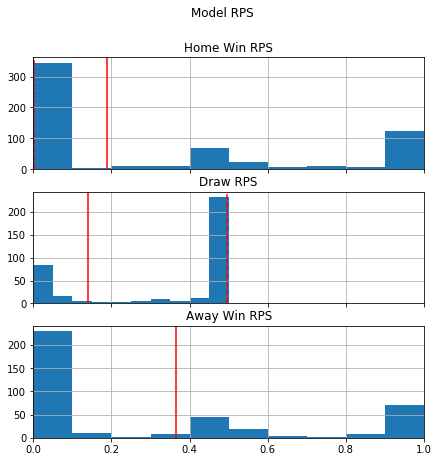

In [87]:
# validation_df0 = validation_df[validation_df['n_fold'] == 1]
hwin_rpss = validation_df[validation_df['result'] == 'hwin']['model_rps']
draw_rpss = validation_df[validation_df['result'] == 'draw']['model_rps']
awin_rpss = validation_df[validation_df['result'] == 'awin']['model_rps']

bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)

ax1.hist(hwin_rpss, bins=bins)
ax1.set_xlim(0,1.0)
ax1.axvline(baselineRPS_hwin, color='r')
ax1.axvline(hwin_rpss.median(), color='r', linestyle='dashed')
ax1.set_title('Home Win RPS')
ax1.grid()
print(hwin_rpss.median())

ax2.hist(draw_rpss, bins=bins)
ax2.axvline(baselineRPS_draw, color='r')
ax2.axvline(draw_rpss.median(), color='r', linestyle='dashed')
ax2.set_title('Draw RPS')
ax2.grid()
print(draw_rpss.median())

ax3.hist(awin_rpss, bins=bins)
ax3.axvline(baselineRPS_awin, color='r')
ax3.axvline(awin_rpss.median(), color='r', linestyle='dashed')
ax3.set_title('Away Win RPS')
ax3.grid()
print(awin_rpss.median())

plt.suptitle('Model RPS')
plt.show();

0.144881161549453
0.13840830449826988
0.27989313402490584


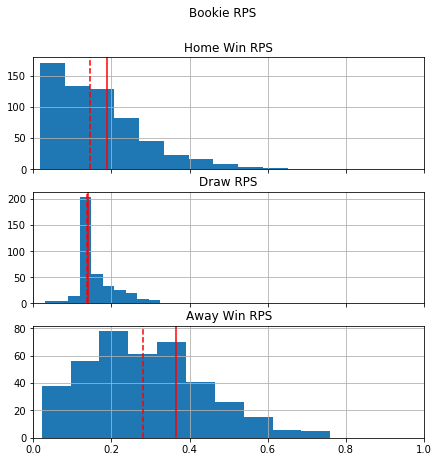

In [88]:
hwin_rpss = validation_df[validation_df['result'] == 'hwin']['bookie_rps']
draw_rpss = validation_df[validation_df['result'] == 'draw']['bookie_rps']
awin_rpss = validation_df[validation_df['result'] == 'awin']['bookie_rps']

bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)

ax1.hist(hwin_rpss, bins=bins)
ax1.set_xlim(0,1.0)
ax1.axvline(baselineRPS_hwin, color='r')
ax1.axvline(hwin_rpss.median(), color='r', linestyle='dashed')
ax1.set_title('Home Win RPS')
ax1.grid()
print(hwin_rpss.median())

ax2.hist(draw_rpss, bins=bins)
ax2.axvline(baselineRPS_draw, color='r')
ax2.axvline(draw_rpss.median(), color='r', linestyle='dashed')
ax2.set_title('Draw RPS')
ax2.grid()
print(draw_rpss.median())

ax3.hist(awin_rpss, bins=bins)
ax3.axvline(baselineRPS_awin, color='r')
ax3.axvline(awin_rpss.median(), color='r', linestyle='dashed')
ax3.set_title('Away Win RPS')
ax3.grid()
print(awin_rpss.median())

plt.suptitle('Bookie RPS')
plt.show();

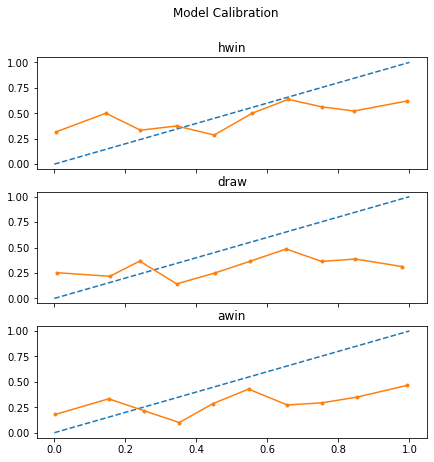

In [89]:
# reliability diagram
bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)
fop1, mpv1 = calibration_curve(validation_df['ordinal_result_1'], validation_df[1], n_bins=10)
# plot perfectly calibrated
ax1.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax1.plot(mpv1, fop1, marker='.')
ax1.set_title('hwin')

fop2, mpv2 = calibration_curve(validation_df['ordinal_result_2'], validation_df[2], n_bins=10)
# plot perfectly calibrated
ax2.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax2.plot(mpv2, fop2, marker='.')
ax2.set_title('draw')

fop3, mpv3 = calibration_curve(validation_df['ordinal_result_3'], validation_df[3], n_bins=10)
# plot perfectly calibrated
ax3.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax3.plot(mpv3, fop3, marker='.')
ax3.set_title('awin')

plt.suptitle('Model Calibration')
plt.show();

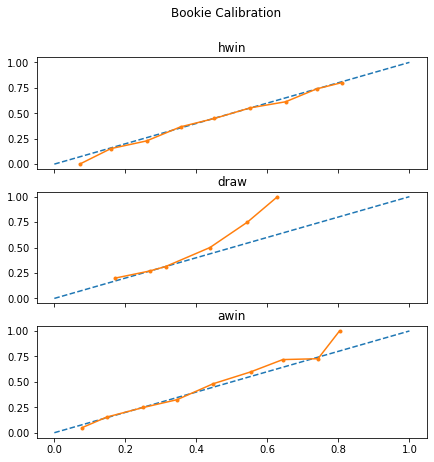

In [90]:
# reliability diagram
bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)
fop1, mpv1 = calibration_curve(validation_df['ordinal_result_1'], validation_df['implied_hwin'], n_bins=10)
# plot perfectly calibrated
ax1.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax1.plot(mpv1, fop1, marker='.')
ax1.set_title('hwin')

fop2, mpv2 = calibration_curve(validation_df['ordinal_result_2'], validation_df['implied_draw'], n_bins=10)
# plot perfectly calibrated
ax2.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax2.plot(mpv2, fop2, marker='.')
ax2.set_title('draw')

fop3, mpv3 = calibration_curve(validation_df['ordinal_result_3'], validation_df['implied_awin'], n_bins=10)
# plot perfectly calibrated
ax3.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax3.plot(mpv3, fop3, marker='.')
ax3.set_title('awin')

plt.suptitle('Bookie Calibration')
plt.show();

In [91]:
# imps = pd.DataFrame(clf.get_booster().get_score(importance_type='gain').items(),
#                     columns=['feature','importance']).sort_values('importance', ascending=False).reset_index(drop=True)

In [92]:
# imps.head(40)

In [93]:
# imps.tail(20)

In [94]:
# clf.explained_variance_ratio_

In [95]:
joblib.dump(clf, SAMP_MODEL_FP) 

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/optimized-model.joblib']

## 8. Simulate Gambling in Test Data

In [96]:

clf = joblib.load(SAMP_MODEL_FP)
clf

GaussianNB(priors=[0.45, 0.275, 0.275], var_smoothing=1e-09)

In [97]:
meta_t = meta_test.copy(deep=True)
X_t = X_test.copy(deep=True)
y_t = y_test.copy(deep=True)

meta_t.reset_index(drop=True, inplace=True)
X_t.reset_index(drop=True, inplace=True)
y_t.reset_index(drop=True, inplace=True)

In [98]:
# X_t = srs.transform(X_t)
test_preds = clf.predict_proba(X_t)
test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
# df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)
df_test = pd.concat([meta_t, test_preds_df], sort=False, axis=1)

df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

df_test['model_rps'] = calc_rps(test_preds_df,
                                meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['bookie_rps'] = calc_rps(meta_t[['implied_hwin', 'implied_draw', 'implied_awin']],
                                 meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['baseline_rps'] = calc_rps(meta_t[['base_hwin_prob', 'base_draw_prob', 'base_awin_prob']],
                                 meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])


# Do custom scoring
baselineRPS_hwin = df_test[df_test['result'] == 'hwin']['baseline_rps'].median()
baselineRPS_draw = df_test[df_test['result'] == 'draw']['baseline_rps'].median()
baselineRPS_awin = df_test[df_test['result'] == 'awin']['baseline_rps'].median()

modelMedRPS_hwin = df_test[df_test['result'] == 'hwin']['model_rps'].median()
modelMedRPS_draw = df_test[df_test['result'] == 'draw']['model_rps'].median()
modelMedRPS_awin = df_test[df_test['result'] == 'awin']['model_rps'].median()

adjMedRPS_hwin = (modelMedRPS_hwin - baselineRPS_hwin) / baselineRPS_hwin  
adjMedRPS_draw = (modelMedRPS_draw - baselineRPS_draw) / baselineRPS_draw 
adjMedRPS_awin = (modelMedRPS_awin - baselineRPS_awin) / baselineRPS_awin
adjRPS = np.mean([adjMedRPS_hwin, adjMedRPS_draw, adjMedRPS_awin])

rps_adj_scores = [adjMedRPS_hwin, adjMedRPS_draw, adjMedRPS_awin]




# Calculate EVs
df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsBbMax']-1)) + ((1- df_test[1]) * -1)
df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsBbMax']-1)) + ((1- df_test[2]) * -1)
df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsBbMax']-1)) + ((1- df_test[3]) * -1)

# df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsBbMean']-1)) + ((1- df_test[1]) * -1)
# df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsBbMean']-1)) + ((1- df_test[2]) * -1)
# df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsBbMean']-1)) + ((1- df_test[3]) * -1)


# # Betting Strategy # 1
# # ## EV > Threshold ##
# EV_threshold = 0.0
# mask = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)

# Betting Strategy # 2
## EV > Threshold - Bet on Maximum EV for each Game ##
EV_threshold = 0.01
mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
mask2 = df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
            df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

mask = np.logical_and(mask1, mask2)
df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)


# # Betting Strategy # 3
# ## EV > Threshold - Bet on Maximum EV for each Game, but no home wins##
# EV_threshold = 0.1
# mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# mask2 = df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
#             df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

# mask = np.logical_and(mask1, mask2)
# mask[:,0] = 0
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)


# # Betting Strategy # 4
# ## EV > Threshold - Bet on Maximum EV for each Game, only bet on draws##
# EV_threshold = 0.1
# mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# mask2 = df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
#             df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

# mask = np.logical_and(mask1, mask2)
# mask[:,0] = 0
# mask[:,1] = 0
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)




# # Betting Strategy # 5
# # ## EV > EV_Threshold - Odds < odds_threshold ##
# EV_threshold = 0.0
# odds_threshold = 4.0

# mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# mask2 = (df_test[['hwinOddsBbMean', 'drawOddsBbMean', 'awinOddsBbMean']] <= odds_threshold).values

# mask = np.logical_and(mask1, mask2)

# df_test['hwin_bet'] = 0 ; df_test['draw_bet'] = 0 ; df_test['awin_bet'] = 0
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = mask


# Do betting
conditions = [(df_test['hwin_bet'] == 1) & (df_test['ordinal_result_1'] == 1), # Place Bet - bet wins
              (df_test['hwin_bet'] == 1) & (df_test['ordinal_result_1'] == 0)] # Place bet - bet loses
choices = [(df_test['hwinOddsBbMax']-1), -1]
# choices = [(df_test['hwinOddsBbMean']-1), -1]
df_test['hwin_rets'] = np.select(conditions, choices, default=0) # default - no bet placed

conditions = [(df_test['draw_bet'] == 1) & (df_test['ordinal_result_2'] == 1), # Place Bet - bet wins
              (df_test['draw_bet'] == 1) & (df_test['ordinal_result_2'] == 0)] # Place bet - bet loses
choices = [(df_test['drawOddsBbMax']-1), -1]
# choices = [(df_test['drawOddsBbMean']-1), -1]
df_test['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [(df_test['awin_bet'] == 1) & (df_test['ordinal_result_3'] == 1), # Place Bet - bet wins
              (df_test['awin_bet'] == 1) & (df_test['ordinal_result_3'] == 0)] # Place bet - bet loses
choices = [(df_test['awinOddsBbMax']-1), -1]
# choices = [(df_test['awinOddsBbMean']-1), -1]
df_test['awin_rets'] = np.select(conditions, choices, default=0)

def get_placed_bet(row):
    if row[0]:
        return 'hwin_bet'
    elif row[1]:
        return 'draw_bet'
    elif row[2]:
        return 'awin_bet'
    else:
        return 'no_bet'
    
df_test['placed_bet'] = df_test[['hwin_bet', 'draw_bet', 'awin_bet']].apply(get_placed_bet, axis=1)


df_test['game_ret'] = df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)

df_test.to_csv(SAVE_FP, index=False)

df_test.head(15)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOddsBbMax,drawOddsBbMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOddsBbMax,hwinOddsBbMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,italy,serie-a,2015-2016,udinese,lazio,2016-01-31,0.0,0.0,draw,5.0,19.0,0.0,0.288462,0.288462,0.423077,0.258742,0.300875,0.440383,1.0,17.0,1.0,4.0,2.40,2.32,0.275,0.275,0.45,3.38,3.21,5.0,8.0,0.0,0.288462,0.423077,0.288462,0.258742,0.440383,0.300875,1.0,11.0,1.0,2.0,3.39,3.18,0.423077,0.288462,0.288462,2,0,1,0,0.578947,1.000000,1.095577e-08,1.691943e-04,9.998308e-01,3,awin,4.998308e-01,0.131102,0.139062,-1.000000,-0.999428,1.399594,False,False,True,0.00,0.0,-1.00,awin_bet,-1.00
1,italy,serie-a,2015-2016,genoa,fiorentina,2016-01-31,0.0,0.0,draw,6.0,15.0,0.0,0.279718,0.306787,0.413495,0.249724,0.237092,0.513183,0.0,11.0,3.0,3.0,2.41,2.34,0.275,0.275,0.45,3.55,3.30,7.0,13.0,0.0,0.279718,0.413495,0.306787,0.249724,0.513183,0.237092,0.0,11.0,2.0,2.0,3.30,3.08,0.413495,0.279718,0.306787,2,0,1,0,0.578947,1.000000,9.066188e-12,3.027793e-07,9.999997e-01,3,awin,4.999997e-01,0.132548,0.139062,-1.000000,-0.999999,1.409999,False,False,True,0.00,0.0,-1.00,awin_bet,-1.00
2,italy,serie-a,2015-2016,bologna,sampdoria,2016-01-31,3.0,2.0,hwin,4.0,14.0,0.0,0.287507,0.462816,0.249677,0.237634,0.470096,0.292268,0.0,14.0,6.0,5.0,4.00,3.58,0.275,0.275,0.45,3.49,3.27,3.0,13.0,2.0,0.287507,0.249677,0.462816,0.237634,0.292268,0.470096,0.0,7.0,5.0,3.0,2.30,2.13,0.249677,0.287507,0.462816,1,1,0,0,0.578947,0.611111,1.812561e-01,6.915898e-01,1.271541e-01,2,draw,3.432549e-01,0.175453,0.189062,-0.583111,1.413648,-0.491384,False,True,False,0.00,-1.0,0.00,draw_bet,-1.00
3,italy,serie-a,2015-2016,ac-milan,inter,2016-01-31,3.0,0.0,hwin,6.0,16.0,0.0,0.288514,0.413955,0.297530,0.331989,0.308313,0.359698,0.0,12.0,3.0,1.0,3.20,2.96,0.275,0.275,0.45,3.49,3.26,5.0,18.0,1.0,0.288514,0.297530,0.413955,0.331989,0.359698,0.308313,0.0,14.0,5.0,3.0,2.63,2.45,0.297530,0.288514,0.413955,1,1,0,0,0.578947,0.611111,9.944775e-01,5.488502e-03,3.403426e-05,1,hwin,1.524978e-05,0.215986,0.189062,1.615476,-0.980845,-0.999891,True,False,False,1.63,0.0,0.00,hwin_bet,1.63
4,italy,serie-a,2015-2016,chievo,juventus,2016-01-31,0.0,4.0,awin,4.0,7.0,2.0,0.250606,0.126974,0.622420,0.268154,0.208493,0.523353,0.0,30.0,10.0,2.0,1.62,1.54,0.275,0.275,0.45,4.00,3.80,0.0,12.0,0.0,0.250606,0.622420,0.126974,0.268154,0.523353,0.208493,0.0,6.0,2.0,3.0,8.10,6.98,0.622420,0.250606,0.126974,3,0,0,1,0.578947,1.000000,2.278062e-27,9.360431e-20,1.000000e+00,3,awin,4.380884e-39,0.079344,0.364063,-1.000000,-1.000000,0.620000,False,False,True,0.00,0.0,0.62,awin_bet,0.62
5,italy,serie-a,2015-2016,sassuolo,as-roma,2016-02-02,0.0,2.0,awin,7.0,15.0,1.0,0.292917,0.307091,0.399992,0.271821,0.357158,0.371021,1.0,13.0,5.0,2.0,2.41,2.34,0.275,0.275,0.45,3.40,3.22,8.0,12.0,0.0,0.292917,0.399992,0.307091,0.271821,0.371021,0.357158,0.0,17.0,6.0,1.0,3.44,3.19,0.399992,0.292917,0.307091,3,0,0,1,0.581579,1.000000,8.890325e-09,6.453324e-05,9.999355e-01,3,awin,2.082843e-09,0.227157,0.364063,-1.000000,-0.999781,1.409844,False,False,True,0.00,0.0,1.41,awin_bet,1.41
6,italy,serie-a,2015-2016,empoli,udinese,2016-02-03,1.0,1.0,draw,3.0,27.0,1.0,0.289735,0.455298,0.254967,0.227063,0.613765,0.159169,0.0,5.0,2.0,6.0,4.11,3.78,0.275,0.275,0.45,3.51,3.33,7.0,11.0,0.0,0.289735,0.254967,0.455298,0.227063,0.159169,0.613765,0.0,19.0,4.0,3.0,2.11,2.04,0.2

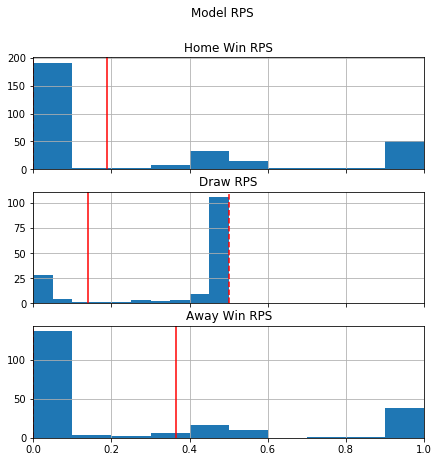

In [99]:
hwin_rpss = df_test[df_test['result'] == 'hwin']['model_rps']
draw_rpss = df_test[df_test['result'] == 'draw']['model_rps']
awin_rpss = df_test[df_test['result'] == 'awin']['model_rps']

bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)

ax1.hist(hwin_rpss, bins=bins)
ax1.set_xlim(0,1.0)
ax1.axvline(baselineRPS_hwin, color='r')
ax1.axvline(hwin_rpss.median(), color='r', linestyle='dashed')
ax1.set_title('Home Win RPS')
ax1.grid()

ax2.hist(draw_rpss, bins=bins)
ax2.axvline(baselineRPS_draw, color='r')
ax2.axvline(draw_rpss.median(), color='r', linestyle='dashed')
ax2.set_title('Draw RPS')
ax2.grid()

ax3.hist(awin_rpss, bins=bins)
ax3.axvline(baselineRPS_awin, color='r')
ax3.axvline(awin_rpss.median(), color='r', linestyle='dashed')
ax3.set_title('Away Win RPS')
ax3.grid()

plt.suptitle('Model RPS')
plt.show();

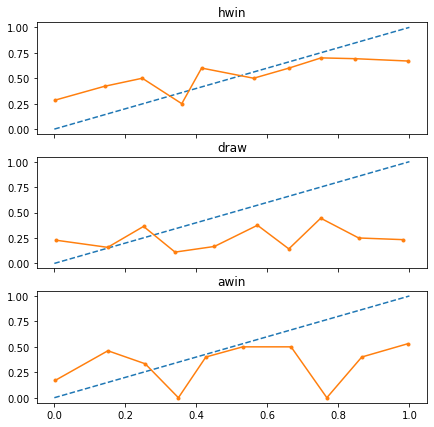

In [100]:
# reliability diagram
bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)
fop1, mpv1 = calibration_curve(df_test['ordinal_result_1'], df_test[1], n_bins=10)
# plot perfectly calibrated
ax1.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax1.plot(mpv1, fop1, marker='.')
ax1.set_title('hwin')

fop2, mpv2 = calibration_curve(df_test['ordinal_result_2'], df_test[2], n_bins=10)
# plot perfectly calibrated
ax2.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax2.plot(mpv2, fop2, marker='.')
ax2.set_title('draw')

fop3, mpv3 = calibration_curve(df_test['ordinal_result_3'], df_test[3], n_bins=10)
# plot perfectly calibrated
ax3.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax3.plot(mpv3, fop3, marker='.')
ax3.set_title('awin')

plt.show();

In [101]:
from sklearn.calibration import CalibratedClassifierCV
calibrator = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
calibrator.fit(X_validate, y_validate)
# evaluate the model
yhat = calibrator.predict_proba(X_t)
yhat

array([[0.26135414, 0.28692265, 0.45172321],
       [0.2211375 , 0.24277158, 0.53609091],
       [0.37908225, 0.3284193 , 0.29249844],
       ...,
       [0.74395128, 0.21129977, 0.04474895],
       [0.14793925, 0.23285112, 0.61920963],
       [0.56682578, 0.24940334, 0.18377088]])

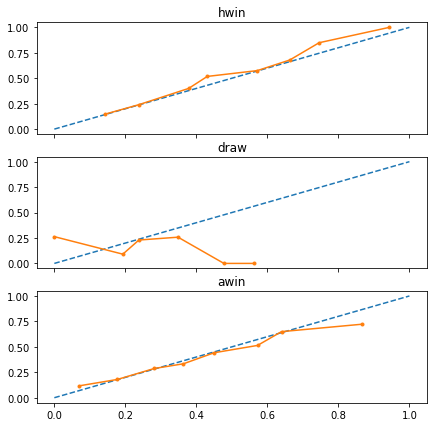

In [102]:
# reliability diagram
bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)
fop1, mpv1 = calibration_curve(df_test['ordinal_result_1'], yhat[:, 0], n_bins=10)
# plot perfectly calibrated
ax1.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax1.plot(mpv1, fop1, marker='.')
ax1.set_title('hwin')

fop2, mpv2 = calibration_curve(df_test['ordinal_result_2'], yhat[:,1], n_bins=10)
# plot perfectly calibrated
ax2.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax2.plot(mpv2, fop2, marker='.')
ax2.set_title('draw')

fop3, mpv3 = calibration_curve(df_test['ordinal_result_3'], yhat[:,2], n_bins=10)
# plot perfectly calibrated
ax3.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax3.plot(mpv3, fop3, marker='.')
ax3.set_title('awin')

plt.show();

In [103]:
print(df_test['hwin_rets'].sum())
print(df_test['draw_rets'].sum())
print(df_test['awin_rets'].sum())
print()
print(f"Total profit/loss: {df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()}")

9.28
-11.08
16.729999999999997

Total profit/loss: 14.929999999999989


In [104]:
print(f"n_bets: {df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")
print(f"n_games: {len(df_test)}")
print(f"Total Return: {df_test['game_ret'].sum()}")     
print(f"Unit Ret per Game: {df_test['game_ret'].sum()/ len(df_test)}")
print(f"Unit Ret per Bet: {df_test['game_ret'].sum()/ df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")

n_bets: 683
n_games: 683
Total Return: 14.929999999999989
Unit Ret per Game: 0.021859443631039515
Unit Ret per Bet: 0.021859443631039515


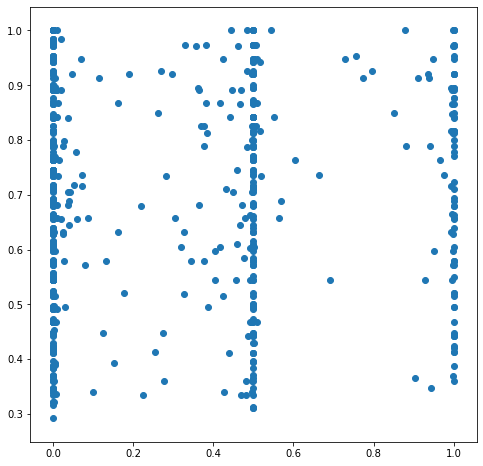

In [105]:
df_play = df_test.copy(deep=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_play['model_rps'], df_play['seasonPercentile'] )
plt.show();

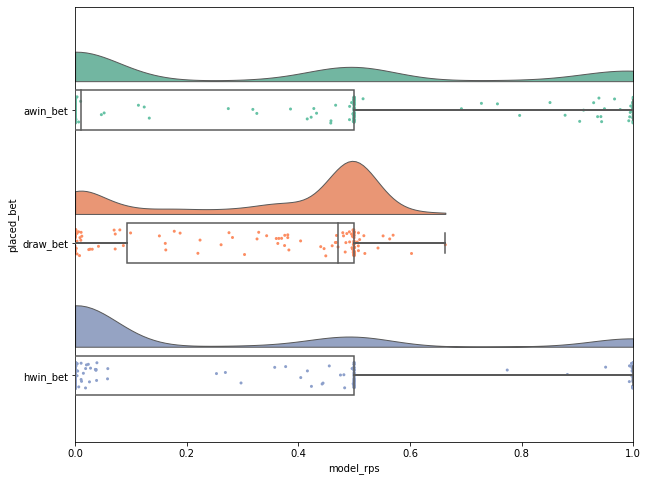

pred hwin: 9.28 on 283 bets
pred draw: -11.08 on 131 bets
pred awin: 16.729999999999997 on 269 bets
683 bets returning 14.929999999999989 over 683 games


In [106]:
import ptitprince as pt
fig, ax = plt.subplots(figsize=(10,8))
ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df_play, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
ax.set_xlim(0.0, 1.0)
#plt.axvline(x=0.1, c='r')
plt.show();
print(f'pred hwin: {df_play["hwin_rets"].sum()} on {df_play["hwin_bet"].sum()} bets')
print(f'pred draw: {df_play["draw_rets"].sum()} on {df_play["draw_bet"].sum()} bets')
print(f'pred awin: {df_play["awin_rets"].sum()} on {df_play["awin_bet"].sum()} bets')
print(f'{df_play[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()} bets returning {df_play["game_ret"].sum()} over {len(df_play)} games')

In [107]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_play2 = df_play.copy(deep=True)
df_play2 = df_play2[df_play2['placed_bet'] != 'no_bet']
df_play2['placed_bet'] = df_play2['placed_bet'].str[0:4]

cm = confusion_matrix(y_target=df_play2['result'], 
                      y_predicted=df_play2['placed_bet'], 
                      binary=False)
cm

array([[139,  36,  40],
       [ 71,  34,  53],
       [ 59,  61, 190]])

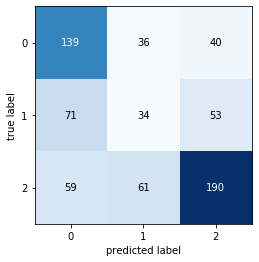

In [108]:
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()